In [ ]:
# Kaggleからデータセットのダウンロードと解凍
# Downloading and extracting the dataset from Kaggle
import pandas as pd

# Google Driveをマウント
from google.colab import drive
drive.mount('/content/drive')

# Kaggleのインストール
!pip install -q kaggle

# Kaggle APIの設定
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/Colab\ Notebooks/data/INFO6147/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# データセットのダウンロード
!kaggle datasets download -d msambare/fer2013

# データセットの解凍
!unzip -q fer2013.zip -d fer2013


Mounted at /content/drive
Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 94% 57.0M/60.3M [00:00<00:00, 130MB/s]
100% 60.3M/60.3M [00:00<00:00, 121MB/s]


Training with dropout_rate=0.3, learning_rate=0.001
Epoch 0/14, Loss: 1.5639, Accuracy: 38.62%
Epoch 1/14, Loss: 1.2878, Accuracy: 50.93%
Epoch 2/14, Loss: 1.1451, Accuracy: 56.56%
Epoch 3/14, Loss: 1.0041, Accuracy: 62.04%
Epoch 4/14, Loss: 0.8778, Accuracy: 66.91%
Epoch 5/14, Loss: 0.7404, Accuracy: 72.05%
Epoch 6/14, Loss: 0.6313, Accuracy: 75.78%
Epoch 7/14, Loss: 0.4544, Accuracy: 83.02%
Epoch 8/14, Loss: 0.4015, Accuracy: 84.70%
Epoch 9/14, Loss: 0.3740, Accuracy: 85.74%
Epoch 10/14, Loss: 0.3490, Accuracy: 86.60%
Epoch 11/14, Loss: 0.3262, Accuracy: 87.62%
Epoch 12/14, Loss: 0.3052, Accuracy: 88.14%
Epoch 13/14, Loss: 0.2913, Accuracy: 88.83%
Epoch 14/14, Loss: 0.2758, Accuracy: 89.47%
Dropout Rate: 0.3, Learning Rate: 0.001, Test Accuracy: 57.80%


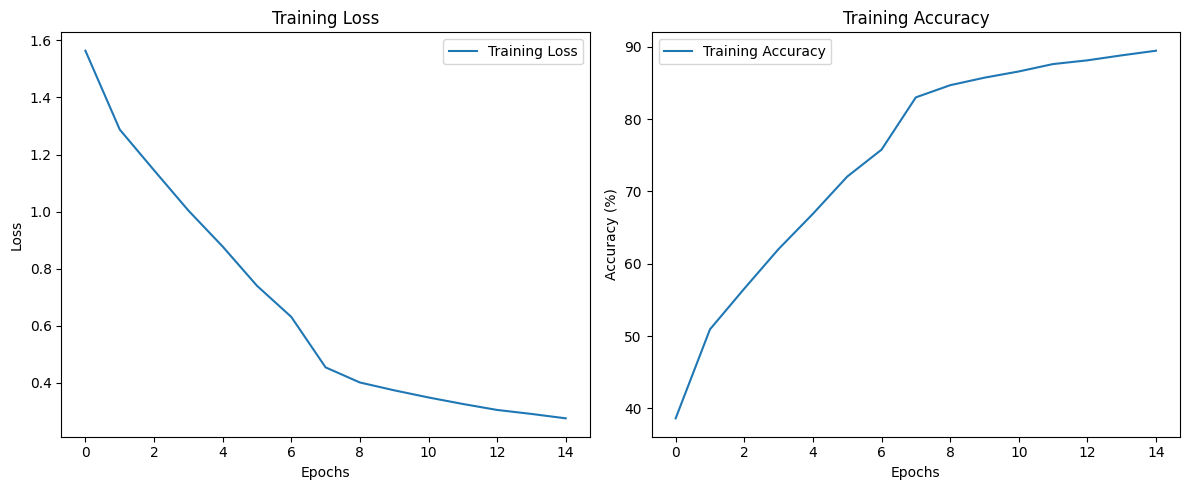

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np

# Mapping of emotion labels to numerical values
label_mapping = {
    'angry': 0,
    'disgust': 1,
    'fear': 2,
    'happy': 3,
    'neutral': 4,
    'sad': 5,
    'surprise': 6
}

class FERDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label_name, label_idx in label_mapping.items():
            label_dir = os.path.join(root_dir, label_name)
            for img_name in os.listdir(label_dir):
                self.image_paths.append(os.path.join(label_dir, img_name))
                self.labels.append(label_idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_root_dir = 'fer2013/train'
test_root_dir = 'fer2013/test'

train_dataset = FERDataset(root_dir=train_root_dir, transform=transform)
test_dataset = FERDataset(root_dir=test_root_dir, transform=transform)

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Model(nn.Module):
    def __init__(self, dropout_rate):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 12 * 12, 128)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 7)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 12 * 12)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

criterion = nn.CrossEntropyLoss()

# Training function with logging for loss and accuracy
def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=15):
    model.train()
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        scheduler.step()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        print(f"Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    return model, train_losses, train_accuracies

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Set the hyperparameters
dropout_rate = 0.3
learning_rate = 0.001

print(f"Training with dropout_rate={dropout_rate}, learning_rate={learning_rate}")

model = Model(dropout_rate).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model, train_losses, train_accuracies = train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=15)

accuracy = evaluate_model(model, test_loader)

print(f"Dropout Rate: {dropout_rate}, Learning Rate: {learning_rate}, Test Accuracy: {accuracy:.2f}%")

# Plotting the results
plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


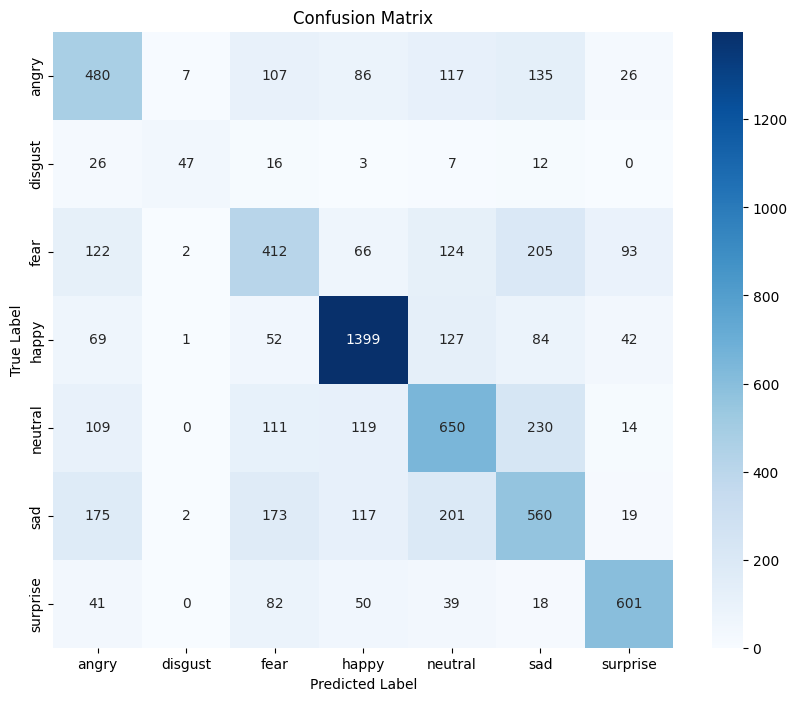

Classification Report:
              precision    recall  f1-score   support

       angry       0.47      0.50      0.48       958
     disgust       0.80      0.42      0.55       111
        fear       0.43      0.40      0.42      1024
       happy       0.76      0.79      0.77      1774
     neutral       0.51      0.53      0.52      1233
         sad       0.45      0.45      0.45      1247
    surprise       0.76      0.72      0.74       831

    accuracy                           0.58      7178
   macro avg       0.60      0.54      0.56      7178
weighted avg       0.58      0.58      0.58      7178



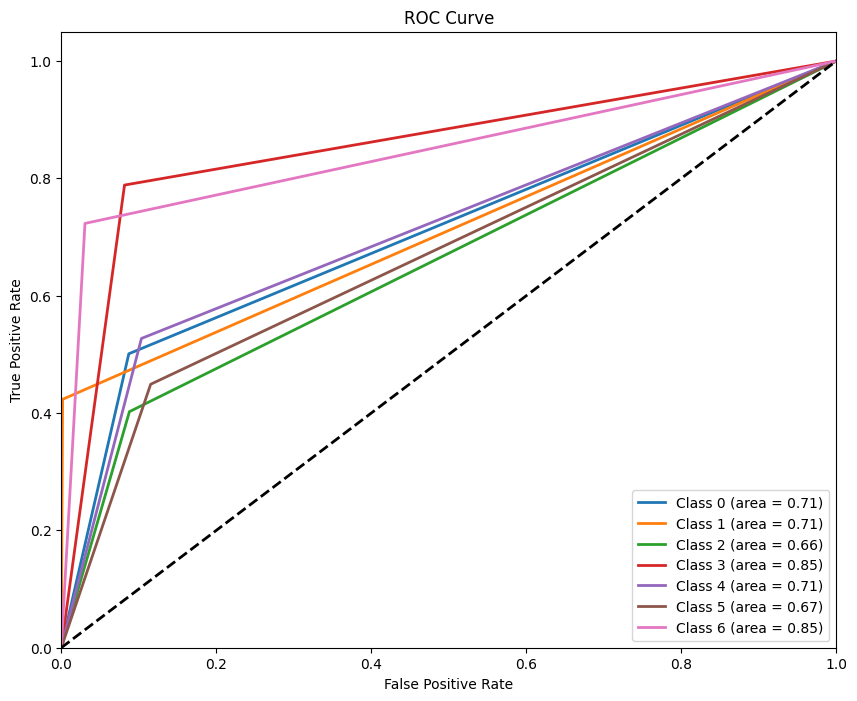

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc  # 'auc'を追加
import torch
import numpy as np

# モデルの評価関数
# Function to evaluate the model
def evaluate_model_detailed(model, test_loader):
    model.eval()
    true_labels = []
    predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            predictions.extend(predicted.cpu().numpy())

    return true_labels, predictions

# 混同行列のプロット関数
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# ROC曲線のプロット関数
# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred, num_classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred == i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# 評価の実行
# Execute evaluation
true_labels, predictions = evaluate_model_detailed(model, test_loader)

# 混同行列の計算とプロット
# Calculate and plot confusion matrix
cm = confusion_matrix(true_labels, predictions)
plot_confusion_matrix(cm, classes=list(label_mapping.keys()))

# 分類レポートの表示
# Display classification report
print('Classification Report:')
print(classification_report(true_labels, predictions, target_names=list(label_mapping.keys())))

# ROC曲線のプロット
# Plot ROC curves
plot_roc_curve(np.array(true_labels), np.array(predictions), num_classes=len(label_mapping))


In [ ]:
# Save the trained model
model_save_path = '/content/drive/MyDrive/Colab Notebooks/data/INFO6147/model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to /content/drive/MyDrive/Colab Notebooks/data/INFO6147/model.pth


Image: 1.jpg
  Angry: 0.14
  Disgust: 0.01
  Fear: 0.15
  Happy: 0.22
  Sad: 0.16
  Surprise: 0.25
  Neutral: 0.07
---
Image: 2.jpg
  Angry: 0.07
  Disgust: 0.01
  Fear: 0.15
  Happy: 0.25
  Sad: 0.05
  Surprise: 0.07
  Neutral: 0.40
---
Image: 3.jpg
  Angry: 0.19
  Disgust: 0.03
  Fear: 0.16
  Happy: 0.24
  Sad: 0.13
  Surprise: 0.21
  Neutral: 0.04
---
Image: 4.jpg
  Angry: 0.26
  Disgust: 0.01
  Fear: 0.11
  Happy: 0.12
  Sad: 0.25
  Surprise: 0.24
  Neutral: 0.01
---
Image: 5.jpg
  Angry: 0.23
  Disgust: 0.00
  Fear: 0.07
  Happy: 0.51
  Sad: 0.02
  Surprise: 0.15
  Neutral: 0.00
---
Image: 6.jpg
  Angry: 0.12
  Disgust: 0.00
  Fear: 0.08
  Happy: 0.59
  Sad: 0.05
  Surprise: 0.14
  Neutral: 0.01
---
Image: 7.jpg
  Angry: 0.08
  Disgust: 0.00
  Fear: 0.03
  Happy: 0.81
  Sad: 0.02
  Surprise: 0.04
  Neutral: 0.01
---
Image: 8.jpg
  Angry: 0.17
  Disgust: 0.06
  Fear: 0.17
  Happy: 0.16
  Sad: 0.12
  Surprise: 0.15
  Neutral: 0.18
---
Image: 9.jpg
  Angry: 0.13
  Disgust: 0.05
  Fea

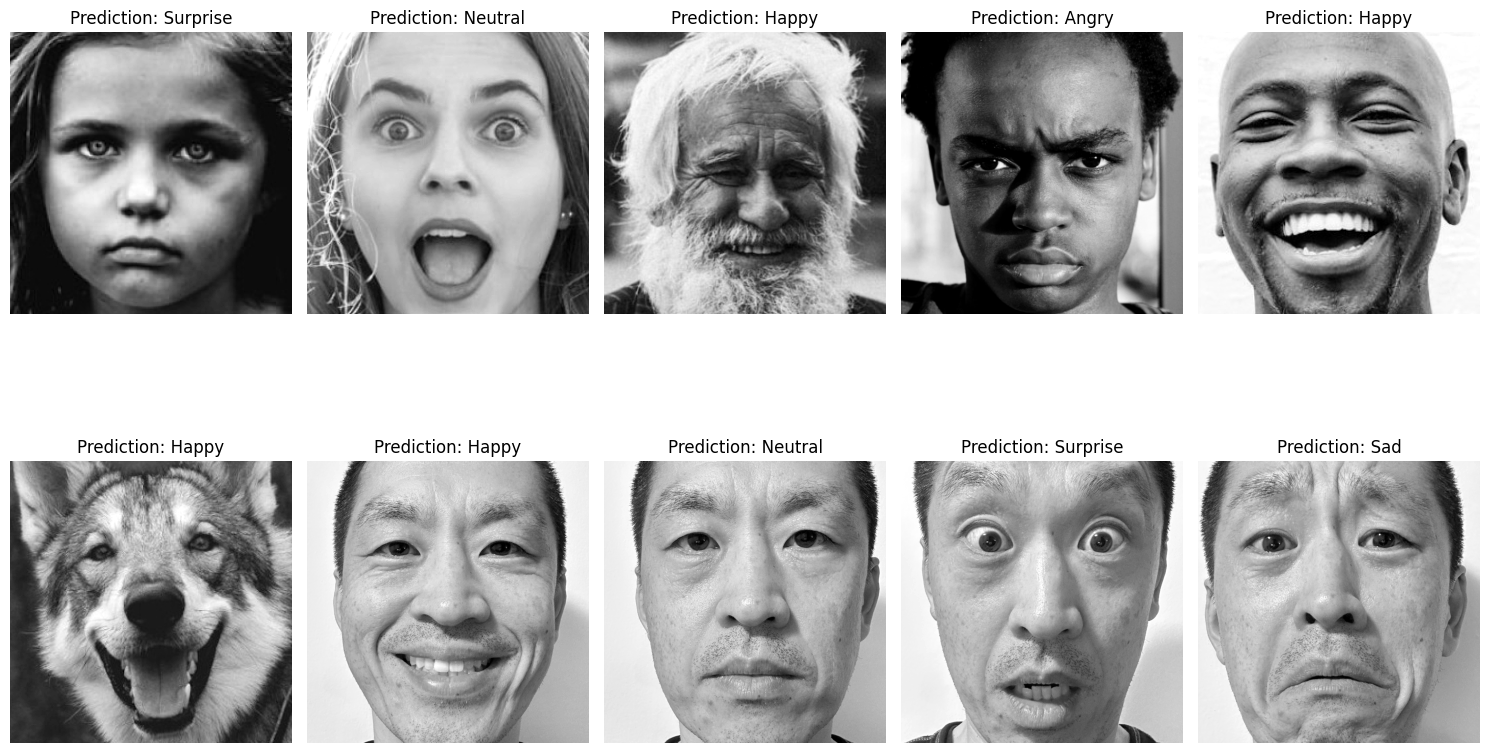

In [ ]:

# モデル定義（事前に定義したModelクラスを再利用）
# Define the model (reuse the previously defined Model class)
class Model(nn.Module):
    def __init__(self, dropout_rate):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 12 * 12, 128)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 7)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 12 * 12)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# デバイスを設定
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 保存されたモデルのパス
# Path to the saved model
model_path = '/content/drive/MyDrive/Colab Notebooks/data/INFO6147/model.pth'

# モデルをロード
# Load the model
model = Model(dropout_rate=0.3).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# 画像の前処理
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 画像パスのリスト
# List of image paths
image_paths = [
    '/content/drive/MyDrive/Colab Notebooks/data/INFO6147/1.jpg',
    '/content/drive/MyDrive/Colab Notebooks/data/INFO6147/2.jpg',
    '/content/drive/MyDrive/Colab Notebooks/data/INFO6147/3.jpg',
    '/content/drive/MyDrive/Colab Notebooks/data/INFO6147/4.jpg',
    '/content/drive/MyDrive/Colab Notebooks/data/INFO6147/5.jpg',
    '/content/drive/MyDrive/Colab Notebooks/data/INFO6147/6.jpg',
    '/content/drive/MyDrive/Colab Notebooks/data/INFO6147/7.jpg',
    '/content/drive/MyDrive/Colab Notebooks/data/INFO6147/8.jpg',
    '/content/drive/MyDrive/Colab Notebooks/data/INFO6147/9.jpg',
    '/content/drive/MyDrive/Colab Notebooks/data/INFO6147/10.jpg'
]

# ラベルマッピング
# Mapping of labels
label_mapping = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

# 画像をロードして予測を行う関数
# Function to load and predict an image
def predict_image(image_path, model, transform, device):
    image = Image.open(image_path).convert('L')  # グレースケールで画像を読み込み
    image = transform(image).unsqueeze(0).to(device)  # 画像を変換し、バッチ次元を追加
    with torch.no_grad():
        output = model(image)
        probabilities = torch.softmax(output, dim=1).cpu().numpy()[0]  # 確率を計算
        _, predicted = torch.max(output, 1)
    return predicted.item(), probabilities

# 各画像の予測結果を表示する関数
# Function to display the prediction results for each image
def display_predictions(image_paths, model, transform, device):
    plt.figure(figsize=(15, 10))
    for idx, image_path in enumerate(image_paths):
        predicted, probabilities = predict_image(image_path, model, transform, device)
        image = Image.open(image_path).convert('L')  # 画像をグレースケールで読み込み
        plt.subplot(2, 5, idx+1)
        plt.imshow(image, cmap='gray')
        plt.title(f'Prediction: {label_mapping[predicted]}')
        plt.axis('off')
        print(f'Image: {os.path.basename(image_path)}')
        for i, (label, prob) in enumerate(zip(label_mapping.values(), probabilities)):
            print(f'  {label}: {prob:.2f}')
        print('---')
    plt.tight_layout()
    plt.show()

# 各画像の予測結果と写真を表示
# Display predictions and images
display_predictions(image_paths, model, transform, device)
